In [3]:
# previous cnn from image to model training and testing(given folder path will contain all images generated)

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import json
import datetime

# === NEW IMPORTS ===
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Constants
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 100
NUM_CLASSES = 8  # adware, backdoor, benign, downloader, spyware, trojan, virus, worms

# this was for the blueish pink images
# Paths
data_dir = r'D:\malware_LLm\final result heatmap\heatmapoutputRGB1\usedHeatmap RGB'
results_dir = r'D:\malware_LLm\final result heatmap\heatmapoutputRGB1'
os.makedirs(results_dir, exist_ok=True)

# Class names
class_names = ['adware', 'backdoor', 'benign', 'downloader', 'spyware', 'trojan', 'virus', 'worm']

# Modified dataset loading to track filenames
def load_dataset_with_filenames(folder_path):
    images = []
    labels = []
    filenames = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.png'):
            class_name = filename.split('_')[0].lower()
            if class_name in class_names:
                img_path = os.path.join(folder_path, filename)
                img = load_img(img_path, color_mode='grayscale', target_size=IMAGE_SIZE)
                img_array = img_to_array(img) / 255.0
                
                images.append(img_array)
                labels.append(class_name)
                filenames.append(filename)
    
    return np.array(images), np.array(labels), np.array(filenames)

# Load dataset with filenames
print("Loading dataset with filenames...")
X, y, filenames = load_dataset_with_filenames(data_dir)
print(f"Loaded {len(X)} images")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = tf.keras.utils.to_categorical(y_encoded, num_classes=NUM_CLASSES)

# Split data while preserving filename alignment
X_train, X_val, y_train, y_val, filenames_train, filenames_val = train_test_split(
    X, y_categorical, filenames, test_size=0.2, random_state=42, stratify=y_encoded
)

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create generators with shuffle=False for validation to maintain order
train_generator = train_datagen.flow(
    X_train, y_train, batch_size=BATCH_SIZE, shuffle=True
)

val_generator = ImageDataGenerator().flow(
    X_val, y_val, batch_size=BATCH_SIZE, shuffle=False
)

# Build CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train model
print("Training model...")
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=len(X_val) // BATCH_SIZE
)

# Create results directory with timestamp
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_dir = os.path.join(results_dir, f"model_{timestamp}")
os.makedirs(model_dir, exist_ok=True)

# Save model and artifacts
model.save(os.path.join(model_dir, 'malware_classifier.keras'))
np.save(os.path.join(model_dir, 'label_encoder.npy'), label_encoder.classes_)

# Generate predictions for validation set
print("Generating predictions...")
val_generator = ImageDataGenerator().flow(X_val, y_val, batch_size=BATCH_SIZE, shuffle=False)
y_pred = model.predict(val_generator)
predicted_classes = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))
true_classes = label_encoder.inverse_transform(np.argmax(y_val, axis=1))

# Create and save predictions CSV
predictions_df = pd.DataFrame({
    'image_name': filenames_val,
    'actual_class': true_classes,
    'predicted_class': predicted_classes
})

csv_path = os.path.join(model_dir, 'predictions.csv')
predictions_df.to_csv(csv_path, index=False)
print(f"Predictions saved to {csv_path}")

# === NEW SECTION: CLASSIFICATION REPORT, CONFUSION MATRIX, METRICS ===
print("Generating classification report and confusion matrix...")

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes, labels=label_encoder.classes_)
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)

# Save confusion matrix heatmap
plt.figure(figsize=(7, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig(os.path.join(model_dir, 'CNNconfusion_matrix.png'))
plt.close()

# Classification report (CSV)
report = classification_report(true_classes, predicted_classes, target_names=label_encoder.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(os.path.join(model_dir, 'classification_report.csv'))

# TP, TN, FP, FN table
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (FP + FN + TP)
metrics_df = pd.DataFrame({
    'Class': label_encoder.classes_,
    'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN
})
metrics_df.to_csv(os.path.join(model_dir, 'tp_tn_fp_fn.csv'), index=False)
# === END NEW SECTION ===

# Save additional training artifacts
def save_training_artifacts():
    # Training history
    with open(os.path.join(model_dir, 'training_history.json'), 'w') as f:
        json.dump(history.history, f)
    
    # Model summary
    with open(os.path.join(model_dir, 'model_summary.txt'), 'w') as f:
        model.summary(print_fn=lambda x: f.write(x + '\n'))
    
    # Metrics
    val_loss, val_acc = model.evaluate(val_generator, verbose=0)
    metrics = {
        'validation_accuracy': float(val_acc),
        'validation_loss': float(val_loss),
        'training_accuracy': float(history.history['accuracy'][-1]),
        'training_loss': float(history.history['loss'][-1])
    }
    with open(os.path.join(model_dir, 'metrics.json'), 'w') as f:
        json.dump(metrics, f, indent=4)
    
    # Training plots
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.savefig(os.path.join(model_dir, 'training_plots.png'))
    plt.close()

save_training_artifacts()

print(f"\nAll results saved to: {model_dir}")
print("Sample predictions:")
print(predictions_df.head())


Loading dataset with filenames...
Loaded 22056 images
Training model...
Epoch 1/100
551/551 [==============================] - 60s 107ms/step - loss: 1.0918 - accuracy: 0.6167 - val_loss: 0.6359 - val_accuracy: 0.7931
Epoch 2/100
551/551 [==============================] - 58s 106ms/step - loss: 0.6943 - accuracy: 0.7625 - val_loss: 0.5186 - val_accuracy: 0.8100
Epoch 3/100
551/551 [==============================] - 58s 104ms/step - loss: 0.5870 - accuracy: 0.8003 - val_loss: 0.5458 - val_accuracy: 0.8214
Epoch 4/100
551/551 [==============================] - 58s 105ms/step - loss: 0.5380 - accuracy: 0.8168 - val_loss: 0.5659 - val_accuracy: 0.8406
Epoch 5/100
551/551 [==============================] - 58s 105ms/step - loss: 0.4864 - accuracy: 0.8327 - val_loss: 0.6033 - val_accuracy: 0.8378
Epoch 6/100
551/551 [==============================] - 59s 108ms/step - loss: 0.4616 - accuracy: 0.8477 - val_loss: 0.5292 - val_accuracy: 0.8230
Epoch 7/100
551/551 [==============================]

In [6]:
# ============================================================
# Fine-Tuned EfficientNet Malware Classifier (Full Version)
# ============================================================

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import json
import datetime

# ============================================================
# Configuration
# ============================================================
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 100
NUM_CLASSES = 8  # adware, backdoor, benign, downloader, spyware, trojan, virus, worm

data_dir = r'D:\malware_LLm\final result heatmap\heatmapoutputRGB1\usedHeatmap RGB'
results_dir = r'D:\malware_LLm\final result heatmap\heatmapoutputRGB1'
os.makedirs(results_dir, exist_ok=True)

class_names = ['adware', 'backdoor', 'benign', 'downloader', 'spyware', 'trojan', 'virus', 'worm']

# ============================================================
# Dataset Loading (convert grayscale → RGB)
# ============================================================
def load_dataset_with_filenames(folder_path):
    images, labels, filenames = [], [], []
    for filename in os.listdir(folder_path):
        if filename.endswith('.png'):
            class_name = filename.split('_')[0].lower()
            if class_name in class_names:
                img_path = os.path.join(folder_path, filename)
                img = load_img(img_path, color_mode='grayscale', target_size=IMAGE_SIZE)
                img_array = img_to_array(img)
                img_array = np.repeat(img_array, 3, axis=-1)  # grayscale to RGB
                images.append(img_array)
                labels.append(class_name)
                filenames.append(filename)
    return np.array(images), np.array(labels), np.array(filenames)

print("Loading dataset with filenames...")
X, y, filenames = load_dataset_with_filenames(data_dir)
print(f"Loaded {len(X)} images")

# Preprocess for EfficientNet
X = preprocess_input(X)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = tf.keras.utils.to_categorical(y_encoded, num_classes=NUM_CLASSES)

# Split data
X_train, X_val, y_train, y_val, filenames_train, filenames_val = train_test_split(
    X, y_categorical, filenames, test_size=0.2, random_state=42, stratify=y_encoded
)

# Data augmentation
train_datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2,
                                   height_shift_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')

train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
val_generator = ImageDataGenerator().flow(X_val, y_val, batch_size=BATCH_SIZE, shuffle=False)

# ============================================================
# Build Fine-Tuned EfficientNet
# ============================================================
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
base_model.trainable = True

# Unfreeze last 40 layers
for layer in base_model.layers[:-40]:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ============================================================
# Training
# ============================================================
print("Training fine-tuned EfficientNet model...")
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    validation_steps=len(X_val) // BATCH_SIZE
)

# ============================================================
# Save Artifacts and Reports
# ============================================================
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_dir = os.path.join(results_dir, f"EfficientNet_FineTuned_{timestamp}")
os.makedirs(model_dir, exist_ok=True)

model.save(os.path.join(model_dir, 'efficientnet_finetuned_model.keras'))
np.save(os.path.join(model_dir, 'label_encoder.npy'), label_encoder.classes_)

# ============================================================
# Evaluation and Predictions
# ============================================================
print("Generating predictions...")
val_generator = ImageDataGenerator().flow(X_val, y_val, batch_size=BATCH_SIZE, shuffle=False)
y_pred = model.predict(val_generator)
predicted_classes = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))
true_classes = label_encoder.inverse_transform(np.argmax(y_val, axis=1))

# Predictions CSV
predictions_df = pd.DataFrame({
    'image_name': filenames_val,
    'actual_class': true_classes,
    'predicted_class': predicted_classes
})
predictions_df.to_csv(os.path.join(model_dir, 'predictions.csv'), index=False)

# ============================================================
# Confusion Matrix
# ============================================================
cm = confusion_matrix(true_classes, predicted_classes, labels=label_encoder.classes_)
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)

plt.figure(figsize=(7, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('EfficientNet Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig(os.path.join(model_dir, 'EfficientNet_confusion_matrix.png'))
plt.close()

# ============================================================
# Classification Report
# ============================================================
report = classification_report(true_classes, predicted_classes,
                               target_names=label_encoder.classes_,
                               output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(os.path.join(model_dir, 'classification_report.csv'))

# ============================================================
# TP, TN, FP, FN Calculation
# ============================================================
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (FP + FN + TP)
metrics_df = pd.DataFrame({
    'Class': label_encoder.classes_,
    'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN
})
metrics_df.to_csv(os.path.join(model_dir, 'tp_tn_fp_fn.csv'), index=False)

# ============================================================
# Save Training History and Metrics
# ============================================================
# Training history
with open(os.path.join(model_dir, 'training_history.json'), 'w') as f:
    json.dump(history.history, f, indent=4)

# Validation metrics
val_loss, val_acc = model.evaluate(val_generator, verbose=0)
metrics = {
    'validation_accuracy': float(val_acc),
    'validation_loss': float(val_loss),
    'training_accuracy': float(history.history['accuracy'][-1]),
    'training_loss': float(history.history['loss'][-1])
}
with open(os.path.join(model_dir, 'metrics.json'), 'w') as f:
    json.dump(metrics, f, indent=4)

# ============================================================
# Training Plots
# ============================================================
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(model_dir, 'training_plots.png'))
plt.close()

print(f"\n✅ All results saved to: {model_dir}")
print("Sample predictions:")
print(predictions_df.head())


Loading dataset with filenames...
Loaded 22056 images
Training fine-tuned EfficientNet model...
Epoch 1/100
551/551 [==============================] - 166s 285ms/step - loss: 0.7052 - accuracy: 0.7683 - val_loss: 0.4716 - val_accuracy: 0.8351
Epoch 2/100
551/551 [==============================] - 159s 288ms/step - loss: 0.4488 - accuracy: 0.8460 - val_loss: 0.4065 - val_accuracy: 0.8380
Epoch 3/100
551/551 [==============================] - 158s 287ms/step - loss: 0.3922 - accuracy: 0.8666 - val_loss: 0.3427 - val_accuracy: 0.8645
Epoch 4/100
551/551 [==============================] - 158s 286ms/step - loss: 0.3590 - accuracy: 0.8789 - val_loss: 0.3056 - val_accuracy: 0.8848
Epoch 5/100
551/551 [==============================] - 156s 282ms/step - loss: 0.3347 - accuracy: 0.8897 - val_loss: 0.2620 - val_accuracy: 0.9275
Epoch 6/100
551/551 [==============================] - 156s 282ms/step - loss: 0.3223 - accuracy: 0.8921 - val_loss: 0.2661 - val_accuracy: 0.9238
Epoch 7/100
551/551 [=

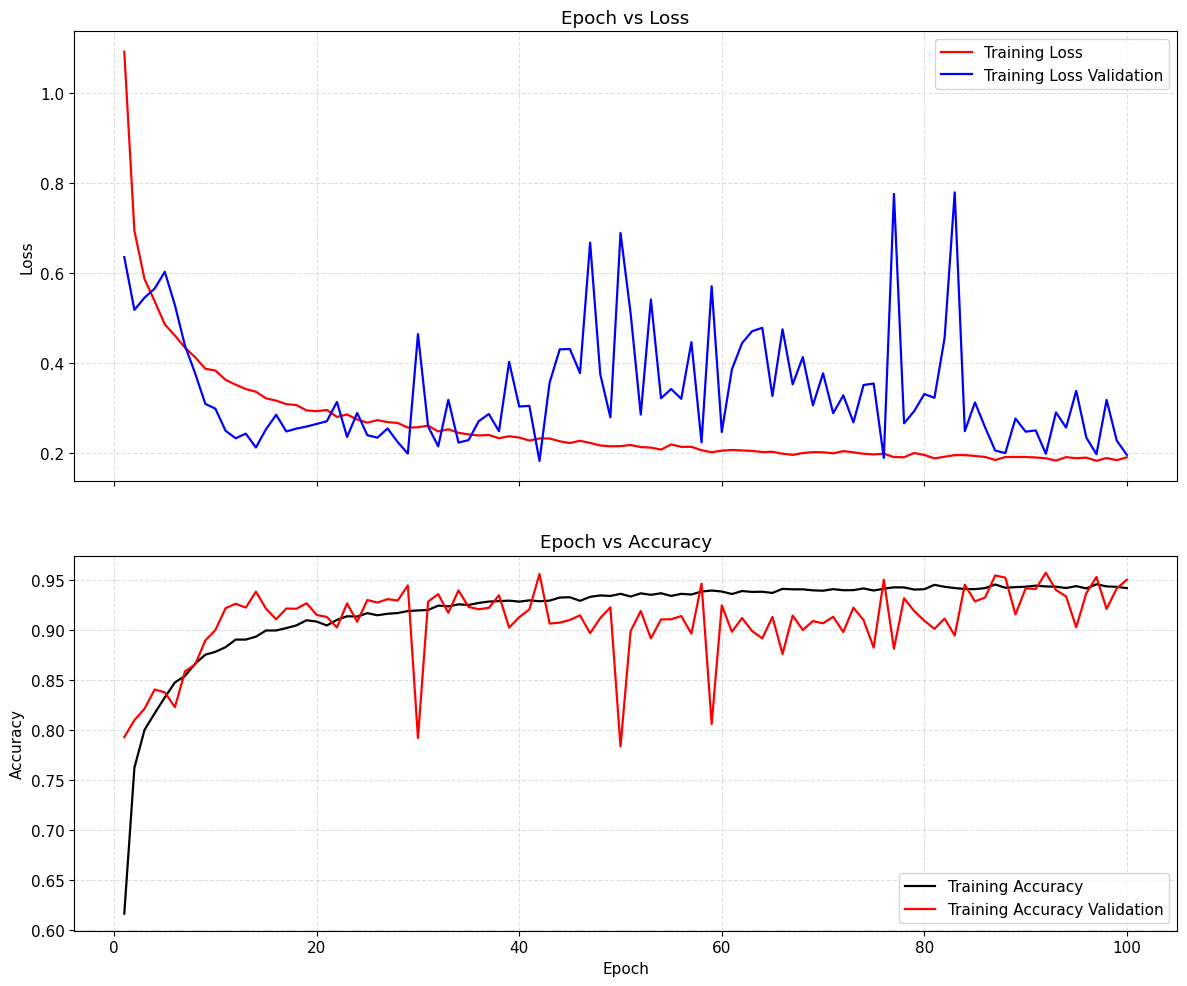

Saved figure to: D:\malware_LLm\Past CNN, CNN , EFFICIENTNET\CNN Past HeatmapRGB


In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# ---- CONFIG ----
csv_path = r"D:\malware_LLm\Past CNN, CNN , EFFICIENTNET\CNN Past HeatmapRGB\training_history.csv"  # change if needed
out_path  = r"D:\malware_LLm\Past CNN, CNN , EFFICIENTNET\CNN Past HeatmapRGB"
dpi = 200
# ----------------

# Load CSV
df = pd.read_csv(csv_path)

# Normalize/guess column names if they differ slightly
def find_col(df, target):
    target = target.lower().replace(" ", "_")
    for c in df.columns:
        if c.lower().replace(" ", "_") == target:
            return c
    return None

col_epoch = find_col(df, "epoch") or df.columns[0]   # fallback: first column
col_train_loss = find_col(df, "train_loss")
col_train_acc = find_col(df, "train_accuracy")
col_val_loss = find_col(df, "val_loss")
col_val_acc = find_col(df, "val_accuracy")

required = [col_epoch, col_train_loss, col_train_acc, col_val_loss, col_val_acc]
if any(c is None for c in required):
    missing = [name for name, c in zip(
        ["epoch","train_loss","train_accuracy","val_loss","val_accuracy"], required) if c is None]
    raise ValueError(f"Missing columns in CSV: {missing}. Found columns: {list(df.columns)}")

# Optionally sort by epoch
df = df.sort_values(col_epoch).reset_index(drop=True)

# Optional smoothing (uncomment to enable)
# df['train_loss_s'] = df[col_train_loss].rolling(window=3, min_periods=1, center=False).mean()
# df['val_loss_s']   = df[col_val_loss].rolling(window=3, min_periods=1, center=False).mean()
# df['train_acc_s']  = df[col_train_acc].rolling(window=3, min_periods=1, center=False).mean()
# df['val_acc_s']    = df[col_val_acc].rolling(window=3, min_periods=1, center=False).mean()

# Plot
plt.rcParams.update({'font.size': 11})
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True,
                               gridspec_kw={'height_ratios': [1.2, 1]})

# Top: Loss
ax1.plot(df[col_epoch], df[col_train_loss], color='red',   label='Training Loss', linewidth=1.6)
ax1.plot(df[col_epoch], df[col_val_loss],   color='blue',  label='Training Loss Validation', linewidth=1.6)
ax1.set_title('Epoch vs Loss')
ax1.set_ylabel('Loss')
ax1.grid(alpha=0.4, linestyle='--')
ax1.legend(loc='upper right', frameon=True)

# Bottom: Accuracy
ax2.plot(df[col_epoch], df[col_train_acc], color='black', label='Training Accuracy', linewidth=1.6)
ax2.plot(df[col_epoch], df[col_val_acc],   color='red',   label='Training Accuracy Validation', linewidth=1.6)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Epoch vs Accuracy')
ax2.grid(alpha=0.4, linestyle='--')
ax2.legend(loc='lower right', frameon=True)

# Nice layout & save
plt.tight_layout()
plt.subplots_adjust(hspace=0.18)
plt.savefig(out_path, dpi=dpi, bbox_inches='tight')
plt.show()
print(f"Saved figure to: {out_path}")


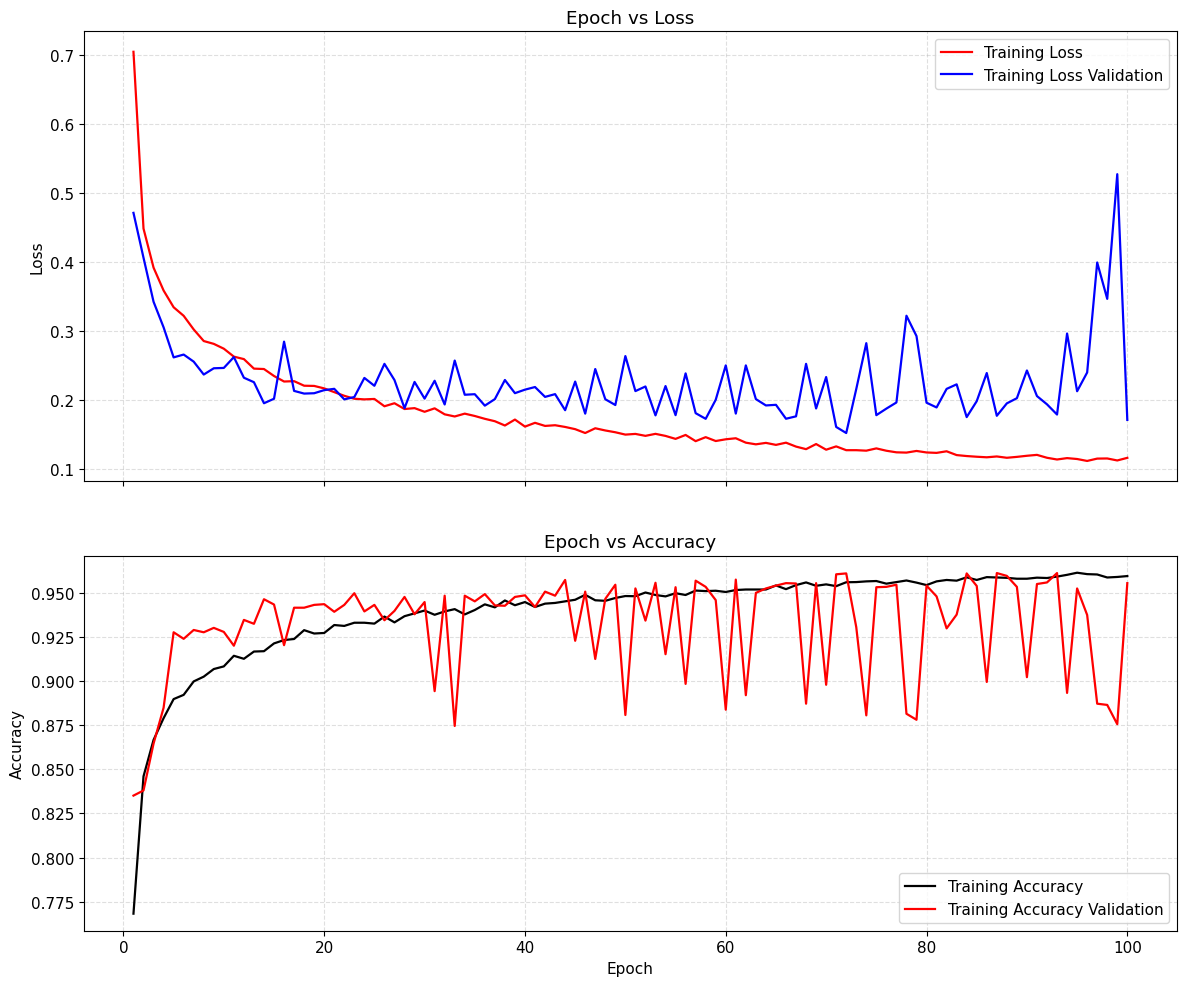

Saved figure to: D:\malware_LLm\Past CNN, CNN , EFFICIENTNET\EfficientNet_FineTuned_20251024_003652


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# ---- CONFIG ----
csv_path = r"D:\malware_LLm\Past CNN, CNN , EFFICIENTNET\EfficientNet_FineTuned_20251024_003652\efficie_ training_history.csv"  # change if needed
out_path  = r"D:\malware_LLm\Past CNN, CNN , EFFICIENTNET\EfficientNet_FineTuned_20251024_003652"
dpi = 200
# ----------------

# Load CSV
df = pd.read_csv(csv_path)

# Normalize/guess column names if they differ slightly
def find_col(df, target):
    target = target.lower().replace(" ", "_")
    for c in df.columns:
        if c.lower().replace(" ", "_") == target:
            return c
    return None

col_epoch = find_col(df, "epoch") or df.columns[0]   # fallback: first column
col_train_loss = find_col(df, "train_loss")
col_train_acc = find_col(df, "train_accuracy")
col_val_loss = find_col(df, "val_loss")
col_val_acc = find_col(df, "val_accuracy")

required = [col_epoch, col_train_loss, col_train_acc, col_val_loss, col_val_acc]
if any(c is None for c in required):
    missing = [name for name, c in zip(
        ["epoch","train_loss","train_accuracy","val_loss","val_accuracy"], required) if c is None]
    raise ValueError(f"Missing columns in CSV: {missing}. Found columns: {list(df.columns)}")

# Optionally sort by epoch
df = df.sort_values(col_epoch).reset_index(drop=True)

# Optional smoothing (uncomment to enable)
# df['train_loss_s'] = df[col_train_loss].rolling(window=3, min_periods=1, center=False).mean()
# df['val_loss_s']   = df[col_val_loss].rolling(window=3, min_periods=1, center=False).mean()
# df['train_acc_s']  = df[col_train_acc].rolling(window=3, min_periods=1, center=False).mean()
# df['val_acc_s']    = df[col_val_acc].rolling(window=3, min_periods=1, center=False).mean()

# Plot
plt.rcParams.update({'font.size': 11})
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True,
                               gridspec_kw={'height_ratios': [1.2, 1]})

# Top: Loss
ax1.plot(df[col_epoch], df[col_train_loss], color='red',   label='Training Loss', linewidth=1.6)
ax1.plot(df[col_epoch], df[col_val_loss],   color='blue',  label='Training Loss Validation', linewidth=1.6)
ax1.set_title('Epoch vs Loss')
ax1.set_ylabel('Loss')
ax1.grid(alpha=0.4, linestyle='--')
ax1.legend(loc='upper right', frameon=True)

# Bottom: Accuracy
ax2.plot(df[col_epoch], df[col_train_acc], color='black', label='Training Accuracy', linewidth=1.6)
ax2.plot(df[col_epoch], df[col_val_acc],   color='red',   label='Training Accuracy Validation', linewidth=1.6)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Epoch vs Accuracy')
ax2.grid(alpha=0.4, linestyle='--')
ax2.legend(loc='lower right', frameon=True)

# Nice layout & save
plt.tight_layout()
plt.subplots_adjust(hspace=0.18)
plt.savefig(out_path, dpi=dpi, bbox_inches='tight')
plt.show()
print(f"Saved figure to: {out_path}")


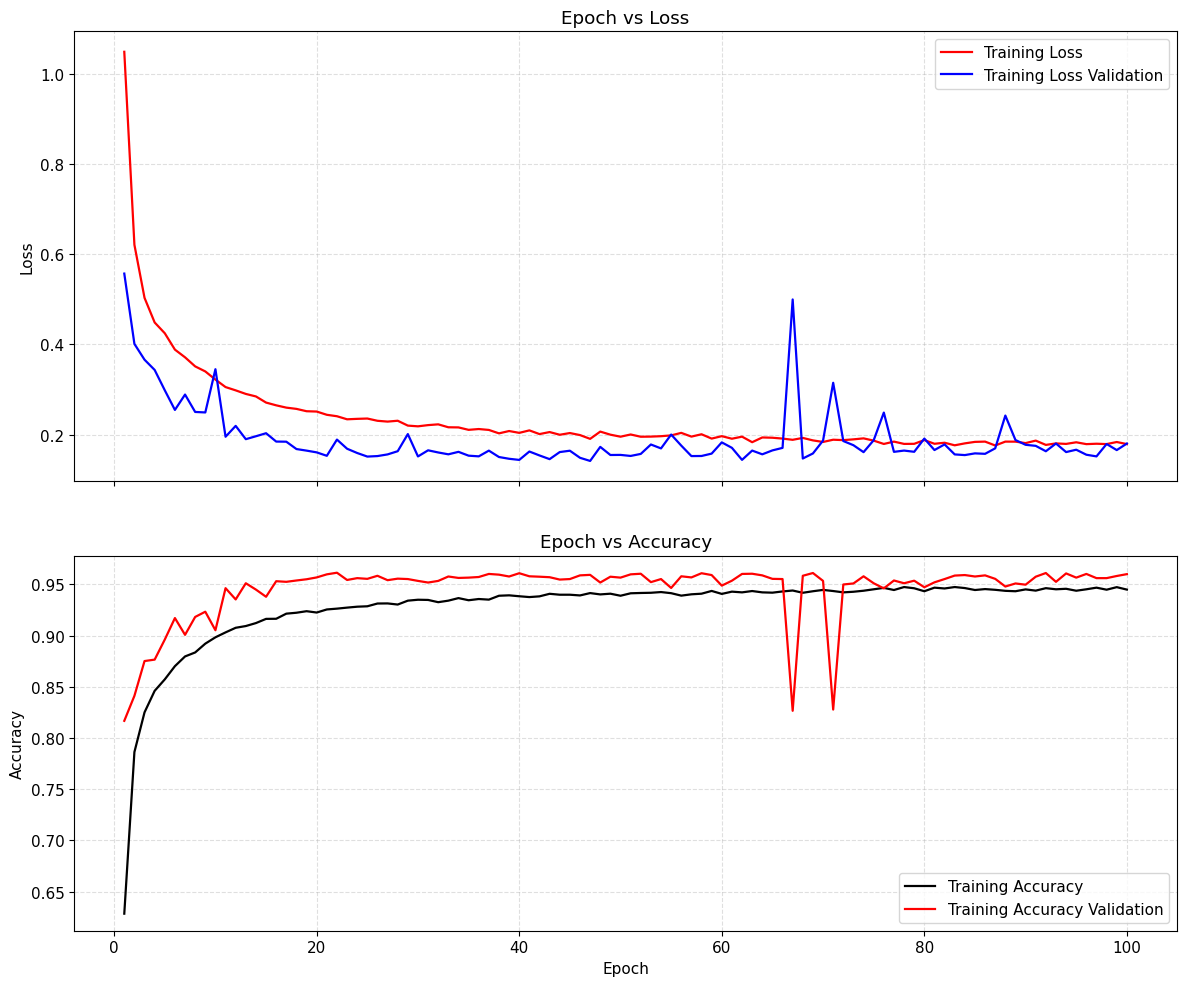

Saved figure to: D:\malware_LLm\Past CNN, CNN , EFFICIENTNET\CNN Model


In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# ---- CONFIG ----
csv_path = r"D:\malware_LLm\Past CNN, CNN , EFFICIENTNET\CNN Model\cnn_training_metrics.csv"  # change if needed
out_path  = r"D:\malware_LLm\Past CNN, CNN , EFFICIENTNET\CNN Model"
dpi = 200
# ----------------

# Load CSV
df = pd.read_csv(csv_path)

# Normalize/guess column names if they differ slightly
def find_col(df, target):
    target = target.lower().replace(" ", "_")
    for c in df.columns:
        if c.lower().replace(" ", "_") == target:
            return c
    return None

col_epoch = find_col(df, "epoch") or df.columns[0]   # fallback: first column
col_train_loss = find_col(df, "train_loss")
col_train_acc = find_col(df, "train_accuracy")
col_val_loss = find_col(df, "val_loss")
col_val_acc = find_col(df, "val_accuracy")

required = [col_epoch, col_train_loss, col_train_acc, col_val_loss, col_val_acc]
if any(c is None for c in required):
    missing = [name for name, c in zip(
        ["epoch","train_loss","train_accuracy","val_loss","val_accuracy"], required) if c is None]
    raise ValueError(f"Missing columns in CSV: {missing}. Found columns: {list(df.columns)}")

# Optionally sort by epoch
df = df.sort_values(col_epoch).reset_index(drop=True)

# Optional smoothing (uncomment to enable)
# df['train_loss_s'] = df[col_train_loss].rolling(window=3, min_periods=1, center=False).mean()
# df['val_loss_s']   = df[col_val_loss].rolling(window=3, min_periods=1, center=False).mean()
# df['train_acc_s']  = df[col_train_acc].rolling(window=3, min_periods=1, center=False).mean()
# df['val_acc_s']    = df[col_val_acc].rolling(window=3, min_periods=1, center=False).mean()

# Plot
plt.rcParams.update({'font.size': 11})
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True,
                               gridspec_kw={'height_ratios': [1.2, 1]})

# Top: Loss
ax1.plot(df[col_epoch], df[col_train_loss], color='red',   label='Training Loss', linewidth=1.6)
ax1.plot(df[col_epoch], df[col_val_loss],   color='blue',  label='Training Loss Validation', linewidth=1.6)
ax1.set_title('Epoch vs Loss')
ax1.set_ylabel('Loss')
ax1.grid(alpha=0.4, linestyle='--')
ax1.legend(loc='upper right', frameon=True)

# Bottom: Accuracy
ax2.plot(df[col_epoch], df[col_train_acc], color='black', label='Training Accuracy', linewidth=1.6)
ax2.plot(df[col_epoch], df[col_val_acc],   color='red',   label='Training Accuracy Validation', linewidth=1.6)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Epoch vs Accuracy')
ax2.grid(alpha=0.4, linestyle='--')
ax2.legend(loc='lower right', frameon=True)

# Nice layout & save
plt.tight_layout()
plt.subplots_adjust(hspace=0.18)
plt.savefig(out_path, dpi=dpi, bbox_inches='tight')
plt.show()
print(f"Saved figure to: {out_path}")


In [1]:

# ============================================
# CNN for Malware Heatmap Images (RGB enforced)
# With Accuracy, Confusion Matrix, Reports
# ============================================

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import json
import datetime

# ============================================
# Configuration
# ============================================
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 100
NUM_CLASSES = 8

# Paths
data_dir = r'D:\malware_LLm\Past CNN, CNN , EFFICIENTNET\usedHeatmap RGB'
results_dir = r'D:\malware_LLm\Past CNN, CNN , EFFICIENTNET'
os.makedirs(results_dir, exist_ok=True)

# Class names
class_names = ['adware', 'backdoor', 'benign', 'downloader', 'spyware', 'trojan', 'virus', 'worm']

# ============================================
# 1️⃣ Dataset Loader (Force RGB)
# ============================================
def load_dataset_force_rgb(folder_path):
    images, labels, filenames = [], [], []
    for fn in os.listdir(folder_path):
        if not fn.lower().endswith('.png'):
            continue
        cls = fn.split('_')[0].lower()
        if cls not in class_names:
            continue
        img_path = os.path.join(folder_path, fn)
        img = load_img(img_path, color_mode='rgb', target_size=IMAGE_SIZE)
        arr = img_to_array(img).astype("float32") / 255.0
        images.append(arr); labels.append(cls); filenames.append(fn)
    X = np.array(images); y = np.array(labels); filenames = np.array(filenames)
    print(f"✅ Loaded {len(X)} images with shape {X.shape}")
    return X, y, filenames

print("📂 Loading dataset (forcing RGB mode)...")
X, y, filenames = load_dataset_force_rgb(data_dir)

# ============================================
# 2️⃣ Encode Labels + Split
# ============================================
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = tf.keras.utils.to_categorical(y_encoded, num_classes=NUM_CLASSES)

X_train, X_val, y_train, y_val, filenames_train, filenames_val = train_test_split(
    X, y_categorical, filenames, test_size=0.2, random_state=42, stratify=y_encoded
)

# ============================================
# 3️⃣ Data Augmentation
# ============================================
train_gen = ImageDataGenerator(
    rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
).flow(X_train, y_train, batch_size=BATCH_SIZE, shuffle=True)

val_gen = ImageDataGenerator().flow(X_val, y_val, batch_size=BATCH_SIZE, shuffle=False)

# ============================================
# 4️⃣ CNN Model
# ============================================
def build_cnn_model(input_shape, num_classes):
    return models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
model = build_cnn_model(input_shape, NUM_CLASSES)

# ============================================
# 5️⃣ Compile & Train
# ============================================
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

print("🚀 Training CNN...")
history = model.fit(
    train_gen,
    steps_per_epoch=len(X_train)//BATCH_SIZE,
    validation_data=val_gen,
    validation_steps=len(X_val)//BATCH_SIZE,
    epochs=EPOCHS
)

# ============================================
# 6️⃣ Save Results
# ============================================
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_dir = os.path.join(results_dir, f"cnn_model_{timestamp}")
os.makedirs(model_dir, exist_ok=True)

model.save(os.path.join(model_dir, 'cnn_malware_model.keras'))
np.save(os.path.join(model_dir, 'label_encoder.npy'), label_encoder.classes_)

# ============================================
# 7️⃣ Predictions & Metrics
# ============================================
y_pred = model.predict(val_gen)
predicted_classes = np.argmax(y_pred, axis=1)
true_classes = np.argmax(y_val, axis=1)

pred_df = pd.DataFrame({
    'image_name': filenames_val,
    'actual_class': label_encoder.inverse_transform(true_classes),
    'predicted_class': label_encoder.inverse_transform(predicted_classes)
})
pred_df.to_csv(os.path.join(model_dir, 'predictions.csv'), index=False)

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.title("CNN Confusion Matrix")
plt.savefig(os.path.join(model_dir, 'confusion_matrix.png'))
plt.close()

# Classification Report
report = classification_report(true_classes, predicted_classes, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(os.path.join(model_dir, "classification_report.csv"))

# TP, TN, FP, FN per class
tp = np.diag(cm)
fp = cm.sum(axis=0) - tp
fn = cm.sum(axis=1) - tp
tn = cm.sum() - (fp + fn + tp)

metrics_df = pd.DataFrame({
    "Class": class_names,
    "TP": tp, "TN": tn, "FP": fp, "FN": fn
})
metrics_df.to_csv(os.path.join(model_dir, "tp_tn_fp_fn.csv"), index=False)

# ============================================
# 8️⃣ Save Training Artifacts
# ============================================
with open(os.path.join(model_dir, 'training_history.json'), 'w') as f:
    json.dump(history.history, f)

with open(os.path.join(model_dir, 'model_summary.txt'), 'w', encoding='utf-8') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

# Training Plots
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('CNN Accuracy'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('CNN Loss'); plt.legend()

plt.savefig(os.path.join(model_dir, 'training_plots.png'))
plt.close()

print(f"\n✅ CNN results saved in: {model_dir}")
print(pred_df.head())   


KeyboardInterrupt: 